In [114]:
import pandas as pd
import geopandas as gpd
import os
import re

def read_airports_data(path='/Users/JO/PhD/hemspy/data/helipad-data/raw-data/helipad-coordinates.csv', radius_column='radius'):
    airports_path = path 
    airports = pd.read_csv(airports_path, sep=';')
    radius = airports[radius_column]
    airports_gdf = gpd.GeoDataFrame(airports, geometry=gpd.points_from_xy(airports.longitude, airports.latitude), crs="EPSG:4326")
    airports_gdf = airports_gdf.to_crs("EPSG:32634") #to metric coords
    airports_gdf.geometry = airports_gdf.geometry.buffer(distance=radius)
    airports_gdf = airports_gdf.to_crs("EPSG:4326") #back to conventional
    return airports_gdf

def read_flights_data(path='/Users/JO/PhD/hemspy/data/fr24-data/raw-data-unzipped-rearranged/flights'):
    flights_path = path
    flights_files = [f for f in os.listdir(flights_path) if f.endswith('.csv')]
    flights_df_list = [pd.read_csv(os.path.join(flights_path, file)) for file in flights_files]
    flights_df = pd.concat(flights_df_list, ignore_index=True)
    flights_df['flight_id'] = flights_df['flight_id'].astype(int)
    return flights_df

def read_positions_data(path='/Users/JO/PhD/hemspy/data/fr24-data/raw-data-unzipped-rearranged/positions', drop_last=False):
    positions_path = path
    positions_files = [os.path.join(positions_path, file) for file in os.listdir(positions_path) if file.endswith('.csv')]
    positions_df_list = []
    regex_pattern = r'_(.*?)\.'
    regex = re.compile(regex_pattern)
    for file in positions_files:
        flight_id_match = regex.search(os.path.basename(file))
        if flight_id_match:
            flight_id = flight_id_match.group(1)
            df = pd.read_csv(file, usecols=['snapshot_id', 'altitude', 'latitude', 'longitude', 'speed'])
            df['flight_id'] = flight_id
            positions_df_list.append(df)
    positions_df = pd.concat(positions_df_list, ignore_index=True)
    positions_df['flight_id'] = positions_df['flight_id'].astype(int)
    if drop_last:
        positions_df = positions_df.groupby('flight_id').apply(lambda x: x.iloc[:-1], include_groups=False).reset_index(drop=True)
    return positions_df

def merge_flights_and_positions_data(positions_df, flights_df):
    d = pd.merge(positions_df, flights_df, on='flight_id', how='left')
    d['UTC'] = pd.to_datetime(d['snapshot_id'], unit='s', utc=True)
    d['UTC_str'] = d['UTC'].astype(str)

    d['date'] = d['UTC'].dt.date
    d['year'] = d['UTC'].dt.year
    return d

def filter_flight_data(d, airports_gdf, include_equip=['EC45', 'A139', 'A169', 'S76', 'AS65'], exclude_callsign=['SEJSR', 'SEJSP', 'SEJRH', 'SEJRI', 'SERJR', 'SEJRK', 'SEJRL', 'SEJRM', 'SEJRN']):
    d = d[d['equip'].isin(include_equip)]
    d = d[~(d['reg'].isin(exclude_callsign))]
    d = gpd.GeoDataFrame(d, geometry=gpd.points_from_xy(d.longitude, d.latitude), crs="EPSG:4326")
    d = gpd.sjoin(d, airports_gdf, how='left', predicate='within')
    d.drop(['index_right', 'icao', 'is_primary_helipad', 'latitude_right', 'reserved', 'flight', 'callsign', 'longitude_right', 'real_to', 'schd_from', 'schd_to'], axis=1, inplace=True)
    d = d.groupby('aircraft_id').apply(lambda x: x.sort_values('UTC'), include_groups=False)
    return d

def process_flight_data():
    airports_gdf = read_airports_data(radius_column='radius')
    flights_df = read_flights_data()
    positions_df = read_positions_data(drop_last=False)
    d = merge_flights_and_positions_data(positions_df, flights_df)
    d = filter_flight_data(d, airports_gdf)
    return d

In [115]:
d = process_flight_data()

In [116]:
def extract_entries_and_exits(d, min_dwell_time):
    """
    Clean the entries and exits data by performing the following operations:
    - Identify transitions into and out of helipad zones
    - Extract the entry and exit times
    - Keep only entries and exits
    - Create a column for UTC_out of landing zone
    - Keep only the zone dwellings with time longer than min_dwell_time
    - Clean up the primary hospital ro
    Parameters:
    - d (geopandas.geodataframe.GeoDataFrame): DataFrame containing flights
    - min_dwell_time (int): Minimum time (in minutes) for a zone dwelling to be considere
    Returns:
    - cleaned_data (geopandas.geodataframe.GeoDataFrame): Cleaned DataFrame
    """
    # Identify transitions into and out of helipad zones
    d_entries_and_exits = d.copy()
    d_entries_and_exits['in_helipad_zone'] = ~d_entries_and_exits['zone_name'].isna()
    d_entries_and_exits['zone_change'] = d_entries_and_exits['in_helipad_zone'].ne(d_entries_and_exits['in_helipad_zone'].shift())
    # Extract the entry and exit times
    d_entries_and_exits['entry'] = (d_entries_and_exits['zone_change']) & (d_entries_and_exits['in_helipad_zone'])
    d_entries_and_exits['exit'] = (d_entries_and_exits['zone_change']) & (~d_entries_and_exits['in_helipad_zone'])
    d_entries_and_exits['UTC_str'] = d_entries_and_exits['UTC'].astype(str)

    # Keep only entries and exits
    d_entries_and_exits = d_entries_and_exits[d_entries_and_exits['entry'] | d_entries_and_exits['exit']]
    # Create column for UTC_out of landing zone
    d_entries_and_exits['UTC_out'] = d_entries_and_exits.groupby('aircraft_id')['UTC'].shift(-1)
    # Keep only the zone dwellings with time longer than min_dwell_time
    d_entries_and_exits['time_in_zone'] = (d_entries_and_exits['in_helipad_zone'] * (d_entries_and_exits['UTC_out'] - d_entries_and_exits['UTC'])).dt.seconds / 60
    d_entries_and_exits = d_entries_and_exits[d_entries_and_exits['time_in_zone'] > min_dwell_time]
    # Clean up primary hospital row
    d_entries_and_exits['is_primary_hospital'] = d_entries_and_exits['is_primary_hospital'].map({1: True, 0: False})
    return d_entries_and_exits

In [117]:
d_entries_and_exits = extract_entries_and_exits(d, min_dwell_time=30)

In [118]:
def create_transfer_dataframe(d: pd.DataFrame, max_transit_time: int, remove_outliers: bool = True) -> pd.DataFrame:
    d_transfer = d.copy()
    d_transfer.reset_index(inplace=True)
    d_transfer['transfer_id'] = np.nan  # Initialize the transfer_id column
    
    # Filter for primary and university hospital landings
    d_primary = d_transfer[d_transfer['is_primary_hospital']]
    d_tertiary = d_transfer[~d_transfer['is_primary_hospital']]
    
    transfer_id = 0
    
    # Iterate over each primary hospital landing
    for idx_primary, row_primary in d_primary.iterrows():
        # Find matching university hospital landings for the same aircraft within the time window
        valid_tertiary_landings = d_tertiary[
            (d_tertiary['aircraft_id'] == row_primary['aircraft_id']) &
            (d_tertiary['UTC'] >= row_primary['UTC_out']) &
            (d_tertiary['UTC'] <= row_primary['UTC_out'] + pd.Timedelta(hours=max_transit_time))
        ]
        
        if not valid_tertiary_landings.empty:
            # Pick the first valid university landing
            first_valid_idx = valid_tertiary_landings.index[0]
            transfer_id += 1
            d_transfer.loc[idx_primary, 'transfer_id'] = transfer_id
            d_transfer.loc[first_valid_idx, 'transfer_id'] = transfer_id
    
    d_transfer.dropna(subset=['transfer_id'], inplace=True)
    
    # Split into sending and receiving dataframe
    d_transfers_sending = d_transfer[d_transfer['is_primary_hospital']]
    d_transfer_receiving = d_transfer[~d_transfer['is_primary_hospital']]
    
    # Left join in transfer id
    d_transfers_merged = pd.merge(d_transfers_sending, d_transfer_receiving, on='transfer_id', suffixes=('_sending', '_receiving'))
    
    # Calculate travel distance in km
    d_transfers_merged['estimated_distance'] = d_transfers_merged['geometry_sending'].to_crs("EPSG:32634").distance(d_transfers_merged['geometry_receiving'].to_crs("EPSG:32634")) / 1000 
    
    # Calculate expected travel time, account for zone radius
    d_transfers_merged['expected_transit_time'] = (d_transfers_merged['estimated_distance'] / 250) * 60
    
    # Clean up columns
    columns_to_keep = ['transfer_id', 'hospital_name_sending', 'hospital_name_receiving', 'year_sending', 'reg_sending', 'UTC_sending', 'UTC_out_sending', 'time_in_zone_sending', 'UTC_receiving', 'zone_name_sending', 'zone_name_receiving', 'radius_sending', 'radius_receiving', 'geometry_sending', 'geometry_receiving', 'estimated_distance', 'expected_transit_time', 'flight_id_receiving', 'aircraft_id_receiving']
    d_transfers_merged = d_transfers_merged[columns_to_keep]
    
    # Calculate transit time (this will be the time from exiting a zone to entering a zone)
    d_transfers_merged['transit_time'] = (d_transfers_merged['UTC_receiving'] - d_transfers_merged['UTC_out_sending']).dt.total_seconds() / 60
    
    d_transfers_merged['transit_time_outlier'] = np.where(
        d_transfers_merged['transit_time'] > (d_transfers_merged['expected_transit_time'] * 20), 
        True, 
        False
    )
    
    d_transfers_merged['transit_time_ratio'] = d_transfers_merged['transit_time'] / d_transfers_merged['expected_transit_time']
    
    if remove_outliers:
        d_transfers_merged = d_transfers_merged[d_transfers_merged['transit_time_outlier'] == False]
    
    return d_transfers_merged

In [119]:
import numpy as np
dat = create_transfer_dataframe(d_entries_and_exits, 3, remove_outliers=False)
dat

,transfer_id,hospital_name_sending,hospital_name_receiving,year_sending,reg_sending,UTC_sending,UTC_out_sending,time_in_zone_sending,UTC_receiving,zone_name_sending,...,radius_receiving,geometry_sending,geometry_receiving,estimated_distance,expected_transit_time,flight_id_receiving,aircraft_id_receiving,transit_time,transit_time_outlier,transit_time_ratio
0,1.0,Universitetssjukhuset Örebro,"Karolinska universitetssjukhuset, Solna",2022,IREDY,2022-04-16 03:12:22+00:00,2022-04-16 06:21:45+00:00,189.383333,2022-04-16 06:55:43+00:00,Universitetssjukhuset Örebro,...,2000.0,POINT (15.32776 59.28182),POINT (18.00043 59.34707),152.429200,36.583008,729989590,3146414,33.966667,False,0.928482
1,2.0,Visby lasarett,"Karolinska universitetssjukhuset, Solna",2022,IREDY,2022-04-22 11:52:59+00:00,2022-04-22 15:10:13+00:00,197.233333,2022-04-22 15:53:52+00:00,Visby lasarett,...,2000.0,POINT (18.26238 57.71612),POINT (18.03415 59.33143),180.403414,43.296819,731218598,3146414,43.650000,False,1.008157
2,3.0,Universitetssjukhuset Örebro,"Karolinska universitetssjukhuset, Solna",2022,IREDY,2022-04-25 13:17:33+00:00,2022-04-25 13:58:47+00:00,41.233333,2022-04-25 15:00:08+00:00,Universitetssjukhuset Örebro,...,3000.0,POINT (15.32138 59.28674),POINT (17.98632 59.63668),156.105979,37.465435,731781447,3146414,61.350000,False,1.637509
3,4.0,Visby lasarett,"Karolinska universitetssjukhuset, Solna",2022,IREDY,2022-04-27 09:06:32+00:00,2022-04-27 10:55:03+00:00,108.516667,2022-04-27 11:38:38+00:00,Visby lasarett,...,2000.0,POINT (18.28099 57.71705),POINT (18.06702 59.34502),181.749738,43.619937,732146208,3146414,43.583333,False,0.999161
4,5.0,Nyköpings lasarett,"Karolinska universitetssjukhuset, Solna",2022,IREDY,2022-04-29 15:55:30+00:00,2022-04-29 17:46:22+00:00,110.866667,2022-04-29 18:03:42+00:00,Skavsta flygplats,...,2000.0,POINT (17.01933 58.83504),POINT (18.00540 59.34265),79.961780,19.190827,732667269,3146414,17.333333,False,0.903209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,7342.0,Lycksele lasarett,Norrlands universitetssjukhus,2024,SEJXF,2024-05-02 08:51:09+00:00,2024-05-02 15:20:13+00:00,389.066667,2024-05-02 17:20:27+00:00,Lycksele lasarett,...,7000.0,POINT (18.56755 64.63266),POINT (20.26417 63.87819),117.602636,28.224633,889753306,4893446,120.233333,False,4.259872
6464,7344.0,Skellefteå sjukhus,Norrlands universitetssjukhus,2024,SEJXF,2024-05-04 15:24:27+00:00,2024-05-04 15:58:47+00:00,34.333333,2024-05-04 16:22:40+00:00,Skellefteå sjukhus,...,7000.0,POINT (20.77910 64.74120),POINT (20.33506 63.87218),99.195094,23.806823,890271192,4893446,23.883333,False,1.003214
6465,7345.0,Lycksele lasarett,Norrlands universitetssjukhus,2024,SEJXF,2024-05-07 21:07:46+00:00,2024-05-08 07:39:21+00:00,631.583333,2024-05-08 08:08:03+00:00,Lycksele lasarett,...,7000.0,POINT (18.57502 64.64043),POINT (20.19509 63.85872),117.287696,28.149047,891133415,4893446,28.700000,False,1.019573
6466,7346.0,Lycksele lasarett,Norrlands universitetssjukhus,2024,SEJXF,2024-05-09 10:02:14+00:00,2024-05-10 08:44:51+00:00,1362.616667,2024-05-10 09:50:08+00:00,Lycksele lasarett,...,7000.0,POINT (18.84287 64.58606),POINT (20.27876 63.87410),105.577608,25.338626,891701614,4893446,65.283333,False,2.576435


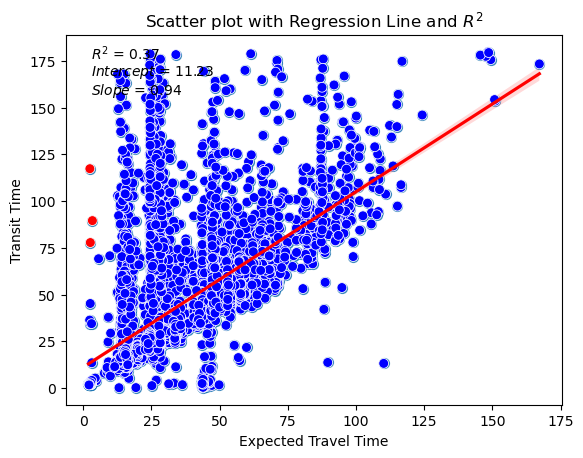

In [120]:
import seaborn as sns
from scipy.stats import linregress
import matplotlib.pyplot as plt
slope, intercept, r_value, p_value, std_err = linregress(dat.expected_transit_time, dat.transit_time)
sns.regplot(x=dat.expected_transit_time, y=dat.transit_time, scatter_kws={'s': 50}, line_kws={'color': 'red'})
sns.scatterplot(x=dat['expected_transit_time'], y=dat['transit_time'], hue=dat['transit_time_outlier'], palette={True: 'red', False: 'blue'}, s=50, legend=False)

# Annotate with R-squared value
plt.text(0.05, 0.95, f'$R^2$ = {r_value**2:.2f}', ha='left', va='center', transform=plt.gca().transAxes)
plt.text(0.05, 0.9, f'$Intercept$ = {intercept:.2f}', ha='left', va='center', transform=plt.gca().transAxes)
plt.text(0.05, 0.85, f'$Slope$ = {slope:.2f}', ha='left', va='center', transform=plt.gca().transAxes)

# Set labels and title
plt.xlabel('Expected Travel Time')
plt.ylabel('Transit Time')
plt.title('Scatter plot with Regression Line and $R^2$')

# Show plot
plt.show()

In [121]:
dat.transit_time_outlier.sum() / len(dat)

0.00046382189239332097

In [122]:
# This function takes a transfer and from the raw data plots all flights for that aircraft within the times of starting the transfer
# and ending it, i.e. if needed all legs will be included
def plot_transfer(raw_df, transfer_df, transfer_id):
    transfer = transfer_df[transfer_df['transfer_id'] == transfer_id]
    aircraft = transfer['aircraft_id_receiving'].iloc[0]
    start_time = transfer['UTC_out_sending'].iloc[0]
    end_time = transfer['UTC_receiving'].iloc[0]
    filtered_df = raw_df[raw_df.index.get_level_values(0) == aircraft]
    filtered_df = filtered_df[filtered_df['UTC'] > start_time]
    filtered_df = filtered_df[filtered_df['UTC'] < end_time]
    flights_set = filtered_df['flight_id'].unique()
    transfer_flights = raw_df[raw_df['flight_id'].isin(flights_set)]
    transfer_flights = transfer_flights[['geometry', 'flight_id', 'UTC_str', 'reg', 'zone_name', 'altitude', 'speed', 'snapshot_id']]
    n_legs = len(flights_set)
    return transfer_flights.explore()

In [123]:
check = np.random.choice(dat.query('transit_time_outlier == True').transfer_id)
plot_transfer(d,dat,transfer_id=check)

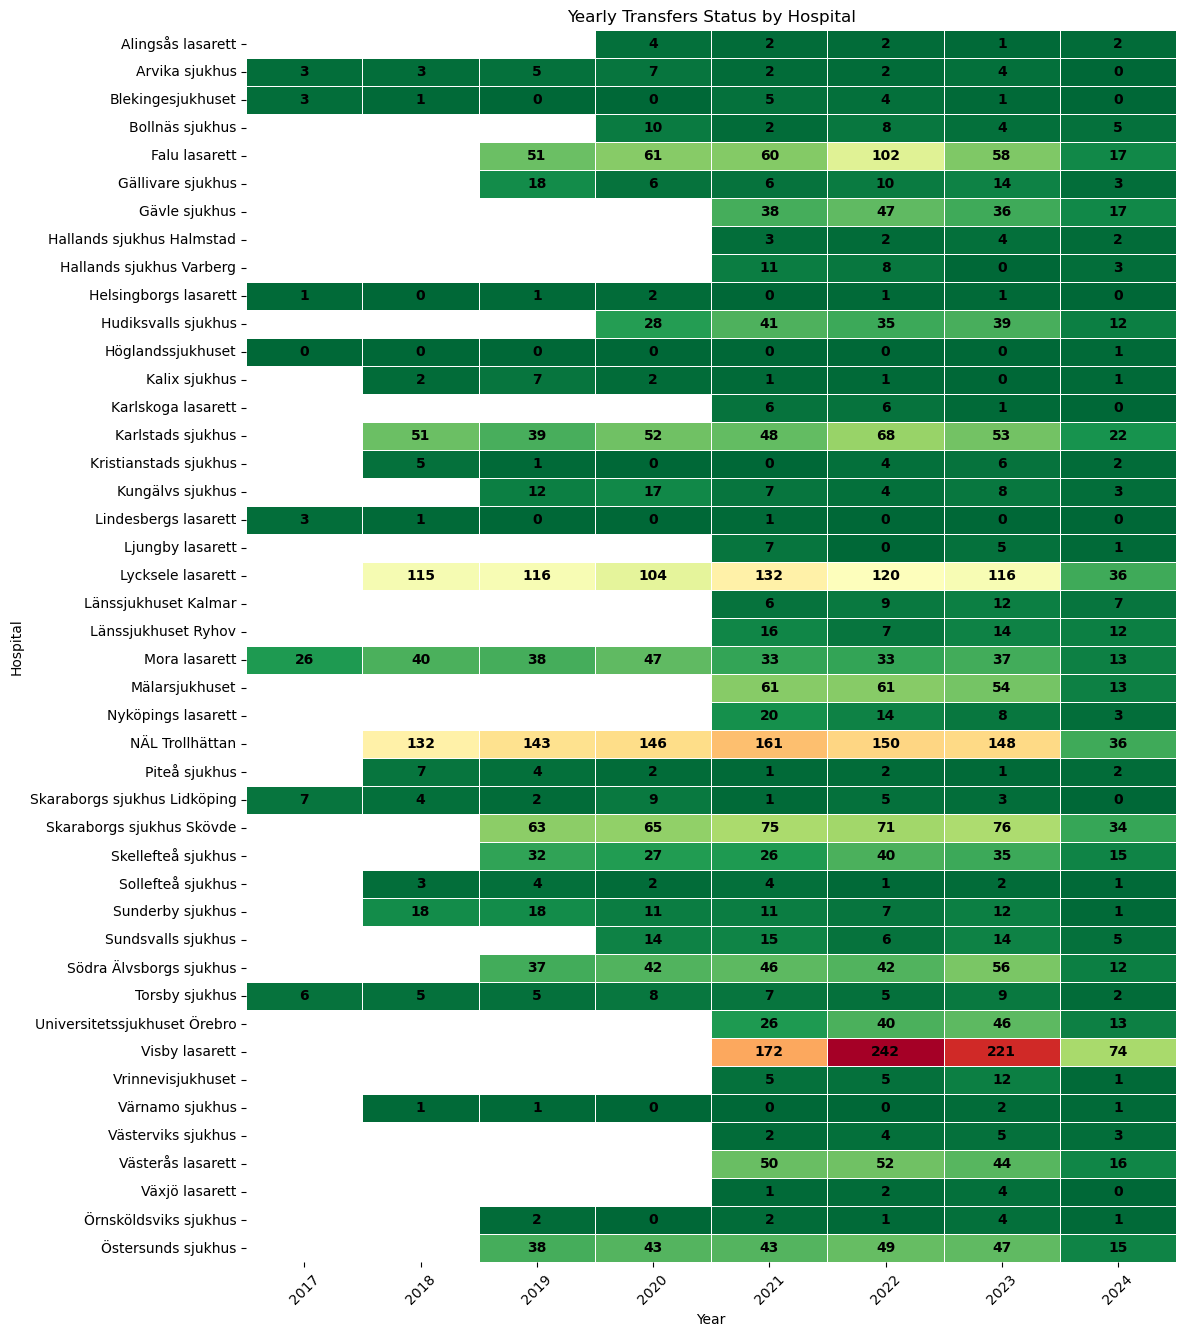

In [124]:
def count_yearly_transfers(x):
    hospital = x.index
    years = [2018, 2017, 2019, 2020, 2021, 2022, 2023, 2024]
    counts = []
    for year in years:
        yearly_count = x.query(f"year_sending == {year}").transfer_id.nunique(dropna=False)
        counts.append(yearly_count)

    return pd.DataFrame({'year': years, 'transfers': counts})

# Calculate yearly transfers
yearly_transfers = dat.query("transit_time_outlier == False").groupby('hospital_name_sending').apply(lambda x: count_yearly_transfers(x), include_groups=False)
yearly_transfers = yearly_transfers.reset_index().drop(axis=1, columns='level_1')

def filter_years(df, threshold_proportion):
    hospitals = df['hospital_name_sending'].unique()
    result = []

    for hospital in hospitals:
        hospital_data = df[df['hospital_name_sending'] == hospital].sort_values(by='year')
        mean_2021_2023 = hospital_data[(hospital_data['year'] >= 2021) & (hospital_data['year'] <= 2023)]['transfers'].mean()
        threshold = threshold_proportion * mean_2021_2023
        
        include_rest = False
        status_list = []
        for idx, row in hospital_data.iterrows():
            if row['year'] >= 2021 or row['transfers'] >= threshold:
                include_rest = True
            status_list.append(True if include_rest else False)

        hospital_data['included'] = status_list
        result.append(hospital_data)

    return pd.concat(result)


# Assuming yearly_transfers is already defined
df_filtered = filter_years(yearly_transfers, threshold_proportion=2/3)

# Plot included years per hospital

def plot_transfers_status(df):
    # Create pivot tables for the heatmap
    pivot_table_transfers = df.pivot_table(index='hospital_name_sending', columns='year', values='transfers', aggfunc='first')
    pivot_table_status = df.pivot_table(index='hospital_name_sending', columns='year', values='included', aggfunc='first')

    # Create a mask for the heatmap based on the status
    mask = pivot_table_status.map(lambda x: x == False)

    # Plotting
    plt.figure(figsize=(12, 16))
    sns.heatmap(pivot_table_transfers, annot=True, fmt='d', cmap='RdYlGn_r', cbar=False, linewidths=0.5,
                mask=mask, annot_kws={'size': 10, 'weight': 'bold', 'color': 'black'})

    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    plt.title('Yearly Transfers Status by Hospital')
    plt.xlabel('Year')
    plt.ylabel('Hospital')
    plt.show()

plot_transfers_status(df_filtered)

In [130]:
dat.query("hospital_name_sending == 'Östersunds sjukhus'").sort_values(by="UTC_sending")

,transfer_id,hospital_name_sending,hospital_name_receiving,year_sending,reg_sending,UTC_sending,UTC_out_sending,time_in_zone_sending,UTC_receiving,zone_name_sending,...,radius_receiving,geometry_sending,geometry_receiving,estimated_distance,expected_transit_time,flight_id_receiving,aircraft_id_receiving,transit_time,transit_time_outlier,transit_time_ratio
103,111.0,Östersunds sjukhus,Akademiska sjukhuset,2017,SEJIC,2017-06-01 21:39:14+00:00,2017-06-02 12:09:53+00:00,870.650000,2017-06-02 14:41:49+00:00,Göviken,...,7000.0,POINT (14.86564 63.12642),POINT (17.62916 59.87516),391.118600,93.868464,228143231,4892963,151.933333,False,1.618577
104,112.0,Östersunds sjukhus,Akademiska sjukhuset,2017,SEJIC,2017-06-22 11:00:29+00:00,2017-06-22 15:10:10+00:00,249.683333,2017-06-22 17:32:42+00:00,Göviken,...,7000.0,POINT (14.90530 63.17977),POINT (17.63201 59.87523),395.857236,95.005737,231971878,4892963,142.533333,False,1.500260
105,113.0,Östersunds sjukhus,Akademiska sjukhuset,2017,SEJIC,2017-07-19 13:25:49+00:00,2017-07-19 14:53:30+00:00,87.683333,2017-07-19 17:19:02+00:00,Göviken,...,7000.0,POINT (14.79700 63.28343),POINT (17.59915 59.78853),417.076943,100.098466,237448359,4892963,145.533333,False,1.453902
106,114.0,Östersunds sjukhus,"Karolinska universitetssjukhuset, Solna",2017,SEJIC,2017-07-29 12:50:39+00:00,2017-07-29 21:30:56+00:00,520.283333,2017-07-29 21:44:12+00:00,Göviken,...,2000.0,POINT (14.54098 63.12317),POINT (18.01503 59.36036),458.937584,110.145020,239574093,4892963,13.266667,False,0.120447
136,144.0,Östersunds sjukhus,Akademiska sjukhuset,2017,SEJID,2017-08-21 11:51:28+00:00,2017-08-21 13:59:02+00:00,127.566667,2017-08-21 14:52:52+00:00,Göviken,...,7000.0,POINT (14.72833 63.09887),POINT (17.68067 59.84722),395.102765,94.824664,244335827,4892964,53.833333,False,0.567714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,416.0,Östersunds sjukhus,Norrlands universitetssjukhus,2024,SEJRA,2024-04-24 14:43:07+00:00,2024-04-24 16:24:06+00:00,100.983333,2024-04-24 17:24:36+00:00,Göviken,...,7000.0,POINT (14.89522 63.17372),POINT (20.16181 63.80512),271.594192,65.182606,887751173,4893249,60.500000,False,0.928162
380,419.0,Östersunds sjukhus,Norrlands universitetssjukhus,2024,SEJRA,2024-04-28 17:13:29+00:00,2024-04-30 04:51:08+00:00,697.650000,2024-04-30 05:53:52+00:00,Göviken,...,7000.0,POINT (14.89010 63.22478),POINT (20.16593 63.79880),270.257150,64.861716,889074595,4893249,62.733333,False,0.967186
4362,4794.0,Östersunds sjukhus,Akademiska sjukhuset,2024,SEJSK,2024-05-06 20:31:20+00:00,2024-05-06 21:06:49+00:00,35.483333,2024-05-06 23:53:46+00:00,Göviken,...,7000.0,POINT (14.76064 63.08345),POINT (17.67554 59.79066),398.599127,95.663790,890807874,4893291,166.950000,False,1.745174
381,420.0,Östersunds sjukhus,Norrlands universitetssjukhus,2024,SEJRA,2024-05-10 19:51:47+00:00,2024-05-11 00:55:44+00:00,303.950000,2024-05-11 02:00:27+00:00,Göviken,...,7000.0,POINT (14.63216 63.07123),POINT (20.17035 63.80082),288.074037,69.137769,891911803,4893249,64.716667,False,0.936054


In [126]:
from datetime import date
import geopandas
airports = pd.read_csv("/Users/JO/PhD/hemspy/data/helipad-data/raw-data/helipad-coordinates.csv", sep=";")

airports_gdf = geopandas.GeoDataFrame(airports, geometry=geopandas.points_from_xy(airports.longitude, airports.latitude), crs="EPSG:4326")
airports_gdf = airports_gdf.to_crs("EPSG:32634") #to metric coords
airports_gdf.geometry = airports_gdf.geometry.buffer(distance=airports.radius)
airports_gdf = airports_gdf.to_crs("EPSG:4326") #back to conventional

m = airports_gdf.explore()

In [127]:
datum = date(2020,10,12)
d[d['UTC'].dt.date == datum].query("reg == 'SEJSK'")[['geometry', 'UTC_str', 'reg', 'zone_name', 'speed', 'altitude']].explore()

In [128]:
d[d['UTC'].dt.date == datum].query("reg == 'SEJSK'").zone_name.unique()

array(['Akademiska sjukhuset', nan, 'Eskilstuna flygplats',
       'Bollnäs sjukhus', 'Gävle sjukhus'], dtype=object)

In [129]:
date = 675